# Climate Analysis




Introduction:
- 5 things you should know about Climate change
- COP26
    - what it means 
    - those involved
    - why
    - outcomes
- Reporting
    - Data sources

### Data Cleaning

In [1]:
import altair as alt
import pandas as pd
import numpy as np
import requests
import json
import ipywidgets as widgets
from ipywidgets import interact

alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
# import data
df = pd.read_csv('data/Environment_Temperature_change_E_All_Data_NOFLAG.csv', encoding='latin-1')

In [3]:
df.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.777,0.062,2.744,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.743,2.465,3.919,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.516,1.336,0.403,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [4]:
# Rename columns
df.columns = df.columns.str.lower().str.replace('y', '')

# Drop columns
df.drop(columns=['area code', 'months code', 'element code', 'unit'], inplace=True)

df['months'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December',
       'Dec\x96Jan\x96Feb', 'Mar\x96Apr\x96May', 'Jun\x96Jul\x96Aug',
       'Sep\x96Oct\x96Nov', 'Meteorological year'], dtype=object)

In [5]:
months_replace = {'Dec\x96Jan\x96Feb': 'quarter_1', 'Mar\x96Apr\x96May': 'quarter_2', 'Jun\x96Jul\x96Aug': 'quarter_3', 'Sep\x96Oct\x96Nov': 'quarter_4'}
df.replace(months_replace, inplace=True)

In [6]:
df.head()

,area,months,element,1961,1962,1963,1964,1965,1966,1967,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,January,Temperature change,0.777,0.062,2.744,-5.232,1.868,3.629,-1.432,...,3.601,1.179,-0.583,1.233,1.755,1.943,3.416,1.201,1.996,2.951
1,Afghanistan,January,Standard Deviation,1.950,1.950,1.950,1.950,1.950,1.950,1.950,...,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950,1.950
2,Afghanistan,February,Temperature change,-1.743,2.465,3.919,-0.202,-0.096,3.397,0.296,...,1.212,0.321,-3.201,1.494,-3.187,2.699,2.251,-0.323,2.705,0.086
3,Afghanistan,February,Standard Deviation,2.597,2.597,2.597,2.597,2.597,2.597,2.597,...,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597,2.597
4,Afghanistan,March,Temperature change,0.516,1.336,0.403,1.659,-0.909,-0.069,-0.759,...,3.390,0.748,-0.527,2.246,-0.076,-0.497,2.296,0.834,4.418,0.234


In [7]:
# Global temperature trend
global_temp = df.melt(var_name='year', value_name='temp', id_vars=('area', 'months', 'element'))

global_temp_grouped = global_temp.groupby(['area', 'element', 'year']).mean()
annual_temp_change = global_temp_grouped.pivot_table('temp', ['area', 'year'], 'element')
annual_temp_change.reset_index(drop=False, inplace=True)
annual_temp_change = annual_temp_change.rename_axis(None, axis=1)
annual_temp_change = annual_temp_change.rename(columns={'Standard Deviation': 'sd', 'Temperature change': 'mean_temp_change'})

pd.to_datetime(annual_temp_change['year'], format='%Y')

annual_temp_change.head()

,area,year,sd,mean_temp_change
0,Afghanistan,1961,1.187765,0.027941
1,Afghanistan,1962,1.187765,-0.197471
2,Afghanistan,1963,1.187765,0.888706
3,Afghanistan,1964,1.187765,-0.905647
4,Afghanistan,1965,1.187765,-0.051824


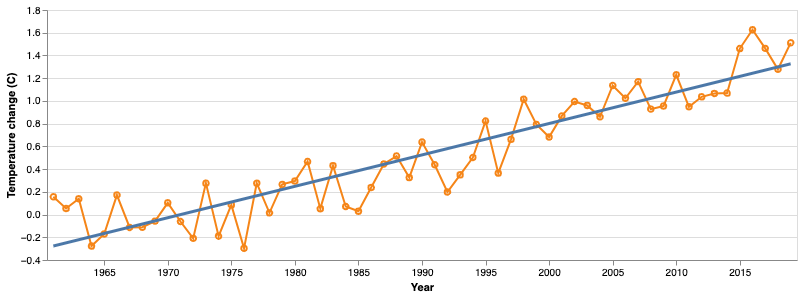

In [8]:
world_temp = annual_temp_change[annual_temp_change.area=='World']

world_plot = alt.Chart(world_temp).mark_point().encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5), labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color=alt.Color('area', legend=None)
)

line_plot = alt.Chart(world_temp).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
)

trend = world_plot.transform_regression(
    'year', 'mean_temp_change', groupby=['months']).mark_line(size=3)


(world_plot + line_plot + trend).properties(
    width=750,
    height=250
)

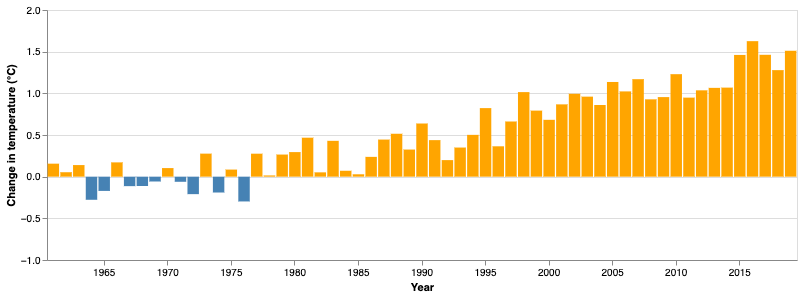

In [9]:
base = alt.Chart(world_temp).transform_joinaggregate(
    avg_temp = 'mean(mean_temp_change)'
).transform_calculate(
    color = 'datum.mean_temp_change > 0 ? "orange" : "steelblue"'
)

bars = base.mark_bar().encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5), labelAngle=0)),
    y=alt.Y("mean(mean_temp_change):Q", 
            title="Change in temperature (°C)",
            scale=alt.Scale(domain=(-1, 2))),
    color=alt.Color('color:N', scale=None)
).properties(
    width=750,
    height=250
)

bars

In [10]:
regions = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

regions_bool = annual_temp_change.area.isin(regions)

region_temps = annual_temp_change[regions_bool]

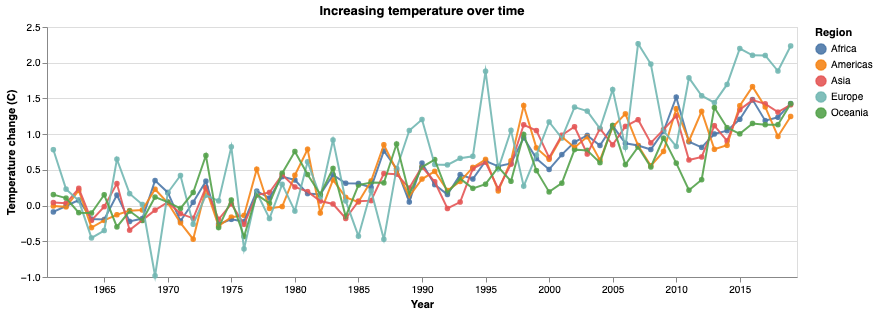

In [11]:
click = alt.selection_multi(fields=['area'], bind='legend')

scatter_plot = alt.Chart(region_temps, title="Increasing temperature over time"
                        ).mark_point(filled=True).encode(
    x=alt.X('year', title="Year", axis=alt.Axis(values=np.arange(1960, 2021, 5), labelAngle=0)),
    y=alt.Y('mean(mean_temp_change)', title="Temperature change (C)") ,
    color=alt.Color('area', title="Region"),
    tooltip='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
).add_selection(click)

line_plot = alt.Chart(region_temps).mark_line().encode(
    x='year',
    y='mean(mean_temp_change)',
    color='area',
    opacity=alt.condition(click, alt.value(0.9), alt.value(0.2))
)

(scatter_plot + line_plot).properties(
    width=750,
    height=250
)

In [12]:
region_temps

,area,year,sd,mean_temp_change
59,Africa,1961,0.337471,-0.089000
60,Africa,1962,0.337471,-0.006353
61,Africa,1963,0.337471,0.077471
62,Africa,1964,0.337471,-0.189471
63,Africa,1965,0.337471,-0.195294
...,...,...,...,...
10202,Oceania,2015,0.545647,1.004412
10203,Oceania,2016,0.545647,1.149647
10204,Oceania,2017,0.545647,1.132588
10205,Oceania,2018,0.545647,1.132706


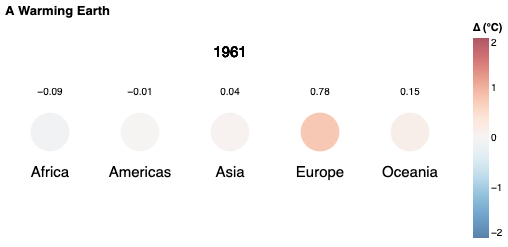

In [25]:
regional_temp = region_temps.copy()
regional_temp['year'] = regional_temp['year'].astype(int)

slider = alt.binding_range(min=1961, max=2019, step=1, name="Year")
select_year = alt.selection_single(name="Year:", fields=['year'],
                                   bind=slider, init={'year': 1961})

plot = alt.Chart(regional_temp, 
                 title=alt.TitleParams(
                    text="A Warming Earth",
                    anchor='start')
    ).mark_circle(size=100).encode(
        alt.X('area', axis=None),
        alt.Color('mean_temp_change', title="∆ (°C)",
                  scale=alt.Scale(scheme="redblue", reverse=True, domain=(-2, 2)))
)

year_label = alt.Chart(regional_temp)

(plot.encode(
    alt.Size("mean_temp_change",
             scale=alt.Scale(range=[1500, 1500]), 
             legend=None)) + 
     plot.mark_text(dy=40, size=15).encode(text='area', color=alt.value('black')) + 
     plot.mark_text(dy=-40, size=10).encode(
         text=alt.Text("mean_temp_change", format=",.2f"),
         color=alt.value('black')) +
      year_label.mark_text(dy=-80, size=15).encode(text='year', color=alt.value('black'))
).add_selection(
    select_year
).transform_filter(
    select_year
).properties(
    width=450,
    height=220
).configure_view(
    strokeWidth=0
)

# improvement - change size of circles -1-0, 0-1, 1-2 rather than gradual increase


## Natural Disasters

In [14]:
# import data
raw_data_nd = pd.read_csv('data/1900_2021_DISASTERS.csv')
raw_data_nd.head()

,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


In [15]:
natural_disasters_df = raw_data_nd[['Year', 'Disaster Subgroup']]

In [16]:
natural_disasters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               16126 non-null  int64 
 1   Disaster Subgroup  16126 non-null  object
dtypes: int64(1), object(1)
memory usage: 252.1+ KB


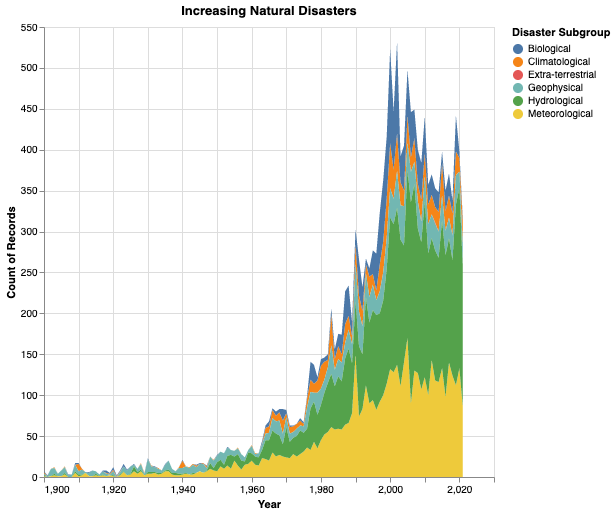

In [17]:
alt.Chart(natural_disasters_df, title="Increasing Natural Disasters").mark_area().encode(
    x=alt.X('Year', title="Year"),
    y=alt.Y('count(Disaster Subgroup)'),
    color='Disaster Subgroup'
).properties(
    width=450,
    height=450
)

In [18]:
clean_df = raw_data_nd.replace(regex=r'\([^)]*\)', value='')
clean_df['Country'] = clean_df['Country'].str.strip()

# remove Biological
bio_index = clean_df[clean_df['Disaster Subgroup'] == 'Biological'].index
clean_df.drop(bio_index, inplace=True)
clean_df = clean_df[['Year', 'Country', 'Disaster Subgroup', 'No Affected', "Total Damages ('000 US$)", 'Total Deaths']]


# natural_disasters_merged[natural_disasters_merged['country-code'].isnull()]['Country'].unique()
test = clean_df[clean_df['Year'] == 2020]
grouped = test.groupby(['Country']).count()

pivot = clean_df.pivot_table(index=["Country", "Year"], aggfunc={'No Affected': np.sum, 'Total Deaths': [np.sum, np.count_nonzero],  "Total Damages ('000 US$)": np.sum})
pivot.columns = pivot.columns.to_series().str.join('_')
pivot.reset_index(drop=False, inplace=True)
pivot.rename(columns={'Country':'country', 
                      'Year': 'year', 
                      'No Affected_sum': 'total_affected',
                      "Total Damages ('000 US$)_sum" :'total_damages_usd',
                      'Total Deaths_count_nonzero':'count', 
                      'Total Deaths_sum': 'total_deaths'}, inplace=True)

In [48]:
country_info = pd.read_csv(
    'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv',
#     converters={'country-code': lambda x: str(x)}
)

country_info['country'] = country_info['name']
country_info['id'] = country_info['country-code']

country_info = country_info.replace({'Bolivia (Plurinational State of)': 'Bolivia',
                          'Iran (Islamic Republic of)': 'Iran',
                           'North Macedonia': 'Macedonia',
                           'Taiwan, Province of China': 'Taiwan',
                           "Korea (Democratic People's Republic of)": 'Korea', 
                           'Moldova, Republic of': 'Moldova',
                           'Russian Federation': 'Russia',
                           'Czechia': 'Czech Republic',
                          })


natural_disasters_merged = pd.merge(pivot, country_info[['country', 'id']], on='country', how='outer')
natural_disasters_merged[natural_disasters_merged['country'] == 'Russia']

,country,year,total_affected,total_damages_usd,count,total_deaths,id
5612,Russia,NaN,NaN,NaN,NaN,NaN,643.0


In [46]:
# natural_disasters = natural_disasters_merged[natural_disasters_merged['year'] == 2000]
# natural_disasters

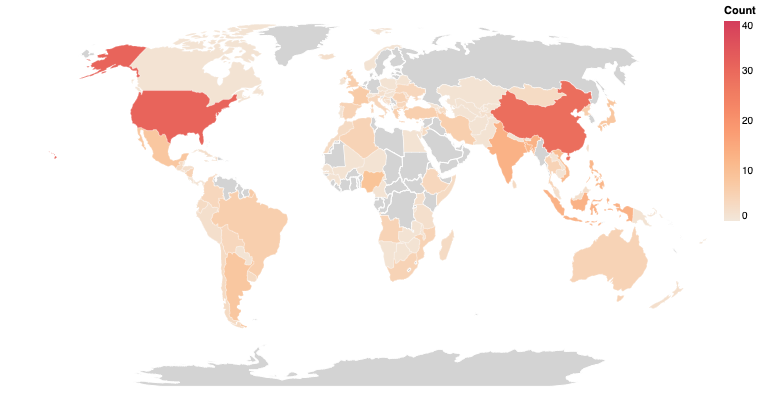

In [63]:
from vega_datasets import data

slider = alt.binding_range(min=1954, max=2021, step=1, name="Year")
select_year = alt.selection_single(name="Year:", fields=['year'],
                                   bind=slider, init={'year': 2000})

countries = alt.topo_feature(data.world_110m.url, 'countries')

background = alt.Chart(countries).mark_geoshape(fill="lightgray", stroke='white')

world_map = alt.Chart(natural_disasters_merged).mark_geoshape(
    stroke='white',
    strokeWidth=0.20
).encode(
        color=alt.Color(
            'count:Q', scale=alt.Scale(scheme="lightorange", domain=[0,40]),
            title="Count"
        ),
        tooltip=[
            alt.Tooltip("country:N", title="Country"),
            alt.Tooltip("count:Q", title="Number of natural disasters"),
            alt.Tooltip("id:Q", title="ID"),

        ]
).add_selection(
    select_year
).transform_filter(
    select_year
).transform_lookup(
        lookup='id',
        from_=alt.LookupData(countries, 
                             key='id', 
                             fields=["type", "properties", "geometry"])
)

final_map = (
    (background + world_map)
    .configure_view(strokeWidth=0)
    .properties(width=700, height=400)
    .project("naturalEarth1")
    .configure_view(stroke=None)
)
final_map

In [50]:
temp_deaths = pd.read_csv('data/extreme_temperature_deaths_annual_number.csv')

In [51]:
temp_deaths

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Afghanistan,0,0,0,NaN,0,NaN,0,0,0,...,0,0,327,0,0,0,21,0,0,1320
1,Albania,0,0,0,NaN,0,NaN,0,0,0,...,0,0,0,0,0,3,0,0,0,0
2,Argentina,0,100,0,NaN,0,NaN,0,0,0,...,0,15,14,0,0,5,0,0,9,0
3,Australia,0,0,0,NaN,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Austria,0,0,0,NaN,0,NaN,0,0,0,...,0,0,0,0,345,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Ukraine,0,0,0,NaN,0,NaN,0,0,0,...,0,0,0,0,0,0,801,0,0,0
69,Uruguay,0,0,0,NaN,0,NaN,0,0,0,...,0,7,0,0,0,0,0,0,0,0
70,United States,0,10,22,NaN,0,NaN,0,0,0,...,257,35,56,14,0,3,33,188,0,0
71,Yugoslavia,0,0,0,NaN,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
temp_deaths.fillna(0, inplace=True)
temp_deaths['2002'] = temp_deaths['2002'].replace({'k': '*1e3'}, regex=True).map(pd.eval).astype(int)


In [53]:
cols = temp_deaths.loc[:, '1970':].columns
temp_deaths['total'] = temp_deaths[cols].sum(axis=1, skipna=True, numeric_only=True)


In [54]:
temp_deaths

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,1999,2000,2001,2002,2003,2004,2005,2006,2007,total
0,Afghanistan,0,0,0,0.0,0,0.0,0,0,0,...,0,327,0,0,0,21,0,0,1320,1892.0
1,Albania,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,3,0,0,0,0,71.0
2,Argentina,0,100,0,0.0,0,0.0,0,0,0,...,15,14,0,0,5,0,0,9,0,143.0
3,Australia,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
4,Austria,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,345,0,0,0,5,0,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,Ukraine,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,0,801,0,0,0,801.0
69,Uruguay,0,0,0,0.0,0,0.0,0,0,0,...,7,0,0,0,0,0,0,0,0,7.0
70,United States,0,10,22,0.0,0,0.0,0,0,0,...,35,56,14,0,3,33,188,0,0,3177.0
71,Yugoslavia,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,38.0


In [55]:
from vega_datasets import data

country_info = pd.read_csv(
    'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv',
)

country_info = country_info.replace({'Bolivia (Plurinational State of)': 'Bolivia',
                          'Czechia': 'Czech Republic',
                           'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
                           'Hong Kong': 'Hong Kong, China',
                           'Korea, Republic of': 'South Korea', 
                           'Moldova, Republic of': 'Moldova',
                           'Russian Federation': 'Russia',
                           'United States of America': 'United States',
                           'Serbia': 'Serbia and Montenegro',
                           'Slovakia': 'Slovak Republic'
                          })

country_info['country'] = country_info['name']

total_deaths = pd.merge(temp_deaths, country_info, on='country', how='left')
total_deaths = total_deaths[['country', 'total', 'country-code']]
total_deaths

,country,total,country-code
0,Afghanistan,1892.0,4.0
1,Albania,71.0,8.0
2,Argentina,143.0,32.0
3,Australia,23.0,36.0
4,Austria,350.0,40.0
...,...,...,...
68,Ukraine,801.0,804.0
69,Uruguay,7.0,858.0
70,United States,3177.0,840.0
71,Yugoslavia,38.0,NaN


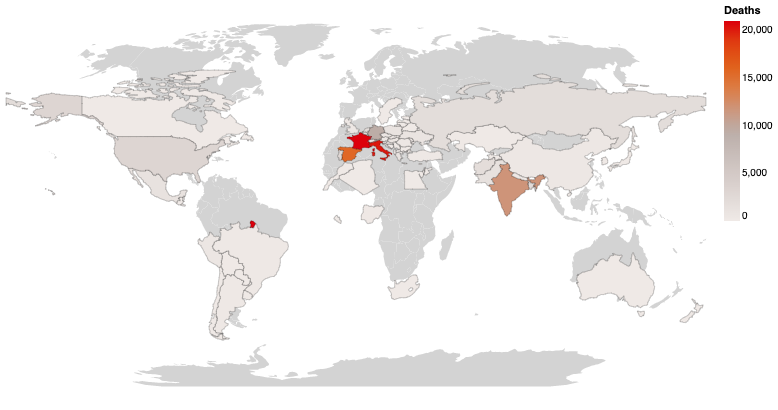

In [57]:
countries = alt.topo_feature(data.world_110m.url, 'countries')

background = alt.Chart(countries).mark_geoshape(fill="lightgrey")

world_map = alt.Chart(countries).mark_geoshape(
    stroke='black',
    strokeWidth=0.20
).encode(
        color=alt.Color(
            'total:Q', scale=alt.Scale(scheme="lightgreyred"),
            title="Deaths"
        ),
        tooltip=[
            alt.Tooltip("country:N", title="Country"),
            alt.Tooltip("total:Q", title="Number of deaths"),
        ],
        ).project(
    "equirectangular"
).transform_lookup(
        lookup='id',
        from_=alt.LookupData(total_deaths, 
                             key='country-code', 
                             fields=["total", "country"])
)

final_map = (
    (background + world_map)
    .configure_view(strokeWidth=0)
    .properties(width=700, height=400)
    .project("naturalEarth1")
)
final_map
